In [12]:
#
# Description: This file runs the main function of the project so we can analyze the results of the different models.
#
# Authors: Christoforou Anthony, ARM Ethan
# Date: 24/06/2023
#
# License: GNU GPL v3.0
#
# This file is part of the Data Mining final project of the University of Geneva.
#

import warnings
warnings.filterwarnings('ignore')

# Predicting Active Wind Power: Model Comparison and Evaluation

Welcome to this Jupyter Notebook, where we will present the results of our efforts in predicting active wind power using various machine learning models. Wind power is a crucial renewable energy source, and accurate prediction of its active power generation is vital for efficient grid management and integration of wind farms.

In this project, we have explored and trained multiple models on historical wind power data, with the aim of predicting the active power output based on various input features such as wind speed, temperature, and atmospheric pressure. Our objective is to identify the most effective model that can provide accurate and reliable predictions for real-time wind power forecasting.

### Dataset

The dataset used in this project was collected from the Supervisory Control and Data Acquisition (SCADA) system of a wind farm. The SCADA data was sampled every 10 minutes from each of the 134 wind turbines in the wind farm, resulting in a total of 4,727,520 records spanning a duration of 245 days. The dataset provides valuable information on wind power generation as well as meteorological and environmental features. By leveraging this rich dataset, we aim to train and evaluate machine learning models for predicting the active wind power output based on the available input features.

### Models

Throughout our analysis, we have explored a range of models, each with its own strengths and characteristics. These models include:

- KNearest Neighbours (**BASELINE**)
- Logistic Regression
- Random Forest Regression
- Long Short-Term Memory (LSTM) Neural Network

Each model brings unique features and capabilities to the table, and we have tailored their configurations to best suit the task of wind power prediction. By comparing and evaluating the performance of these models, we aim to identify the most effective approach for accurate and reliable forecasting.

### Evaluation Metrics

To assess the performance of each model, we have employed mostly **Root Mean Squared Error (RMSE)** because it provides a more interpretable metric by taking the square root of MSE.

### Conclusion

Through this notebook, we will showcase the results and analyses of our trained models. By comparing their performance using various evaluation metrics, we aim to provide insights into the strengths and weaknesses of each approach. This will help us identify the most effective model for accurate and reliable predictions of active wind power, thereby enabling better planning and utilization of wind energy resources.

Let's proceed to the subsequent sections to dive into the results and evaluations of our trained models.

---

Before starting, let's import everything we need

In [13]:

# Libraries
import os
from functools import partial
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import optuna
from optuna.visualization import plot_optimization_history

# Modules
from data import CustomWindFarmDataset
from models import *
from utils import download_data, data_url, relative_position_url, data_dir, relative_position_file

# make figures appear inline
matplotlib.rcParams['figure.figsize'] = (15, 8)
%matplotlib inline

# notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## Setting up

To begin our analysis and model training, we first need to set up the necessary components and load the dataset. This involves defining the hyperparameters for our models and preparing the dataset for further processing.

### Hyperparameters

Hyperparameters play a crucial role in the performance and behavior of our machine learning models. These parameters are set prior to training and are not learned from the data itself. Here are the hyperparameters we will be considering:

- Learning rate: Determines the step size at each iteration during model optimization.
- Number of hidden layers: Specifies the depth of the neural network architecture.
- Number of units in hidden layers: Controls the complexity and capacity of the model.
- Number of epochs: Defines the number of iterations the model will be trained on the data.
- Batch size: Specifies the number of samples propagated through the network at once.

By carefully selecting appropriate hyperparameters, we can optimize the performance and convergence of our models.

In [14]:
# Check if GPU is available
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device.")

# fixed parameters
SEQ_LEN = 1
INPUT_SIZE = 11
OUTPUT_SIZE = 1


Using cuda device.


### Dataset Loading

The dataset, as mentioned earlier, consists of 4,727,520 records collected from the SCADA system of a wind farm. Each record contains information sampled every 10 minutes from the 134 wind turbines in the wind farm, as well as corresponding meteorological and environmental features.

To train and evaluate our models, we need to load this dataset into our Jupyter Notebook. We will preprocess the data, perform any necessary feature engineering, and split it into training and validation sets. This will allow us to effectively train our models on a portion of the data and evaluate their performance on unseen samples.

With the hyperparameters set and the dataset loaded, we are ready to proceed with the model training and evaluation. The subsequent sections will delve into the details of each model, their implementation, and the results obtained.

In [15]:
# Download the data if it is not already present
download_data(data_url, data_dir)
download_data(relative_position_url, relative_position_file)

# Transforms
transform = StandardScaler()
target_transform = MinMaxScaler()

# Load the dataset
dataset = CustomWindFarmDataset(data_dir, relative_position_file, q=SEQ_LEN, device=device, transform=transform.fit_transform, target_transform=target_transform.fit_transform)
dataset = torch.utils.data.Subset(dataset, range(300))

#patv_correlations = dataset.correlations("Patv")
#print("Correlations : ", patv_correlations)

# split the data into train and validation sets
split_size = 0.8 # 80% of the dataset for training
val_size = 0.5
train_size = int(len(dataset)*split_size)
val_size = int((len(dataset)-train_size)*val_size)

# Create train 80 validation 10 test 10 split
train_dataset = torch.utils.data.Subset(dataset, range(train_size))
validation_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size+val_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size+val_size, len(dataset)))
    
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

./data/wtbdata_245days.csv already exists.
./data/sdwpf_baidukddcup2022_turb_location.CSV already exists.
Cleaning data...
Removing rows with missing values...
Rows with missing values removed.
Removing rows with unknown values...
Rows with unknown values removed.
Removing rows with abnormal values...
Rows with abnormal values removed.
Cleaning done.
Train dataset size: 240
Validation dataset size: 30
Test dataset size: 30


---

## Model Evaluation and Results

In this section, we will evaluate the trained models, plot the results, and discuss their performance in predicting the active wind power output.

### Loading the Trained Models

Before proceeding with the evaluation, let's load the trained models that we previously saved. These models have undergone training on the training dataset and are now ready for evaluation on the validation set. By loading the trained models, we can directly use them to make predictions and assess their performance.

In [16]:
# KNN Modeling (BASELINE)
def knn_objective(trial):
    k = trial.suggest_int("k", 1, 10)
    
    knn_model = KNN(k=k, device=device)
    
    acc = knn_model.train(train_dataset, validation_dataset)
    return acc

# Logistic Regression Modeling
def lreg_objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_int("batch_size", 8, 64, step=8)
    epochs = trial.suggest_int("epochs", 100, 400, step=100)
    
    lreg_model = LogisticRegression(INPUT_SIZE, OUTPUT_SIZE, lr=lr, device=device)
    
    _, val_loss = lreg_model.train(train_dataset, validation_dataset, batch_size=batch_size, epochs=epochs, trial=trial)
    return val_loss[-1]
    

# Neural Network Modeling
def nn_objective(trial):
    lr = trial.suggest_float("lr", 1e-6, 1e-1, log=True)
    hidden_size = trial.suggest_int("hidden_size", 1, 10)
    batch_size = trial.suggest_int("batch_size", 8, 64, step=8)
    epochs = trial.suggest_int("epochs", 100, 400, step=100)
    
    nn_model = LSTM(INPUT_SIZE, hidden_size, 1, OUTPUT_SIZE, lr=lr, device=device)
    
    _, val_loss = nn_model.train(train_dataset, validation_dataset, batch_size=batch_size, epochs=epochs, trial=trial)
    return val_loss[-1]

# Random Forest Regression
def rf_objective(trial):
    n_trees = trial.suggest_int("n_trees", 10, 100, step=10)
    max_depth = trial.suggest_int("max_depth", 2, 16)
    batch_size = trial.suggest_int("batch_size", 8, 64, step=8)
    epochs = trial.suggest_int("epochs", 100, 400, step=100)
    
    rf_model = RandomForest(n_trees=n_trees, max_deph=max_depth, device=device)
    
    _, val_loss = rf_model.train(train_dataset, validation_dataset, batch_size=batch_size, epochs=epochs, trial=trial)
    return val_loss[-1]

### Model Evaluation and Predictions

Using the loaded models, we will make predictions on the validation dataset and evaluate their performance using appropriate metrics. The predictions will be compared against the actual values of the active wind power output to assess the accuracy and reliability of each model.

For each model, we will calculate and analyze use the root mean squared error (RMSE) metric, This metric will provide insights into the models' ability to capture the patterns and variability in the wind power data.

In [17]:
# KNN best model
if not os.path.exists('../saved_models/knn_model.pt'):
    knn_study = optuna.create_study(direction="minimize", pruner=optuna.pruners.HyperbandPruner())
    knn_study.optimize(knn_objective, n_trials=10)

    best_knn = KNN(k=knn_study.best_params["k"], device=device)
    best_knn.train(train_dataset, validation_dataset)
else:
    best_knn = KNN.load_model('../saved_models/knn_model.pt')

# Logistic Regression best model
if not os.path.exists('../saved_models/lreg_model.pt'):
    lreg_study = optuna.create_study(direction="minimize", pruner=optuna.pruners.HyperbandPruner())
    lreg_study.optimize(lreg_objective, n_trials=10)

    best_lreg = LogisticRegression(INPUT_SIZE, OUTPUT_SIZE, lr=lreg_study.best_params["lr"], device=device)
    best_lreg.train(train_dataset, validation_dataset, batch_size=lreg_study.best_params["batch_size"], epochs=lreg_study.best_params["epochs"])
else:
    best_lreg = LogisticRegression.load_model('../saved_models/lreg_model.pt')

# Neural Network best model
if not os.path.exists('../saved_models/nn_model.pt'):
    nn_study = optuna.create_study(direction="minimize", pruner=optuna.pruners.HyperbandPruner())
    nn_study.optimize(nn_objective, n_trials=10)

    best_nn = LSTM(INPUT_SIZE, nn_study.best_params["hidden_size"], 1, OUTPUT_SIZE, lr=nn_study.best_params["lr"], device=device)
    best_nn.train(train_dataset, validation_dataset, batch_size=nn_study.best_params["batch_size"], epochs=nn_study.best_params["epochs"])
else:
    best_nn = LSTM.load_model('../saved_models/nn_model.pt')

# Random Forest Regression best model
if not os.path.exists('../saved_models/rf_model.pt'):
    rf_study = optuna.create_study(direction="minimize", pruner=optuna.pruners.HyperbandPruner())
    rf_study.optimize(rf_objective, n_trials=6)

    best_rf = RandomForest(n_trees=rf_study.best_params["n_trees"], max_deph=rf_study.best_params["max_depth"], device=device)
    best_rf.train(train_dataset, validation_dataset, batch_size=rf_study.best_params["batch_size"], epochs=rf_study.best_params["epochs"])
else:
    best_rf = RandomForest.load_model('../saved_models/rf_model.pt')

[I 2023-06-25 17:39:09,605] A new study created in memory with name: no-name-2a0aefbc-cb31-42a9-b849-2de2bfb0c380


[I 2023-06-25 17:39:09,670] Trial 0 finished with value: 0.2697550654411316 and parameters: {'k': 9}. Best is trial 0 with value: 0.2697550654411316.
[I 2023-06-25 17:39:09,733] Trial 1 finished with value: 0.2312786877155304 and parameters: {'k': 5}. Best is trial 1 with value: 0.2312786877155304.


KNN Training finished. Final Accuracy: 0.2697550654411316
KNN Training finished. Final Accuracy: 0.2312786877155304


[I 2023-06-25 17:39:09,804] Trial 2 finished with value: 0.2312786877155304 and parameters: {'k': 5}. Best is trial 1 with value: 0.2312786877155304.
[I 2023-06-25 17:39:09,866] Trial 3 finished with value: 0.24270157516002655 and parameters: {'k': 6}. Best is trial 1 with value: 0.2312786877155304.


KNN Training finished. Final Accuracy: 0.2312786877155304
KNN Training finished. Final Accuracy: 0.24270157516002655


[I 2023-06-25 17:39:09,924] Trial 4 finished with value: 0.26203739643096924 and parameters: {'k': 8}. Best is trial 1 with value: 0.2312786877155304.
[I 2023-06-25 17:39:09,980] Trial 5 finished with value: 0.2500406503677368 and parameters: {'k': 7}. Best is trial 1 with value: 0.2312786877155304.


KNN Training finished. Final Accuracy: 0.26203739643096924
KNN Training finished. Final Accuracy: 0.2500406503677368


[I 2023-06-25 17:39:10,031] Trial 6 finished with value: 0.21902869641780853 and parameters: {'k': 4}. Best is trial 6 with value: 0.21902869641780853.
[I 2023-06-25 17:39:10,098] Trial 7 finished with value: 0.26203739643096924 and parameters: {'k': 8}. Best is trial 6 with value: 0.21902869641780853.


KNN Training finished. Final Accuracy: 0.21902869641780853
KNN Training finished. Final Accuracy: 0.26203739643096924


[I 2023-06-25 17:39:10,152] Trial 8 finished with value: 0.24270157516002655 and parameters: {'k': 6}. Best is trial 6 with value: 0.21902869641780853.
[I 2023-06-25 17:39:10,206] Trial 9 finished with value: 0.2500406503677368 and parameters: {'k': 7}. Best is trial 6 with value: 0.21902869641780853.


KNN Training finished. Final Accuracy: 0.24270157516002655
KNN Training finished. Final Accuracy: 0.2500406503677368


[I 2023-06-25 17:39:10,259] A new study created in memory with name: no-name-38a9258f-1320-4e42-bb69-3d15a1ea3c76


KNN Training finished. Final Accuracy: 0.21902869641780853


LogisticRegression Training: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]
[I 2023-06-25 17:39:29,533] Trial 0 finished with value: 0.657901406288147 and parameters: {'lr': 2.961041368473706e-05, 'batch_size': 32, 'epochs': 100}. Best is trial 0 with value: 0.657901406288147.


LogisticRegression Training finished. Final Accuracy: 0.3900440037250519


LogisticRegression Training: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]
[I 2023-06-25 17:39:46,825] Trial 1 finished with value: 0.6578702926635742 and parameters: {'lr': 1.5439073537128338e-05, 'batch_size': 56, 'epochs': 100}. Best is trial 1 with value: 0.6578702926635742.


LogisticRegression Training finished. Final Accuracy: 0.3904266357421875


LogisticRegression Training:   3%|▎         | 10/300 [00:02<01:01,  4.70it/s]
[I 2023-06-25 17:39:48,955] Trial 2 pruned. 
LogisticRegression Training:   2%|▎         | 10/400 [00:02<01:23,  4.68it/s]
[I 2023-06-25 17:39:51,097] Trial 3 pruned. 
LogisticRegression Training: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]
[I 2023-06-25 17:40:10,716] Trial 4 finished with value: 0.30400389432907104 and parameters: {'lr': 0.009633921212184433, 'batch_size': 16, 'epochs': 100}. Best is trial 4 with value: 0.30400389432907104.


LogisticRegression Training finished. Final Accuracy: 0.08033167570829391


LogisticRegression Training: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
[I 2023-06-25 17:40:47,907] Trial 5 finished with value: 0.27581240981817245 and parameters: {'lr': 0.03145333305271601, 'batch_size': 16, 'epochs': 200}. Best is trial 5 with value: 0.27581240981817245.


LogisticRegression Training finished. Final Accuracy: 0.029389766976237297


LogisticRegression Training: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]
[I 2023-06-25 17:41:05,627] Trial 6 finished with value: 0.6011439561843872 and parameters: {'lr': 0.0002749433195769239, 'batch_size': 64, 'epochs': 100}. Best is trial 5 with value: 0.27581240981817245.


LogisticRegression Training finished. Final Accuracy: 0.3423345386981964


LogisticRegression Training: 100%|██████████| 300/300 [01:02<00:00,  4.80it/s]
[I 2023-06-25 17:42:08,152] Trial 7 finished with value: 0.27173253893852234 and parameters: {'lr': 0.01597381117174193, 'batch_size': 8, 'epochs': 300}. Best is trial 7 with value: 0.27173253893852234.


LogisticRegression Training finished. Final Accuracy: 0.03204042837023735


LogisticRegression Training:   2%|▎         | 10/400 [00:01<01:17,  5.06it/s]
[I 2023-06-25 17:42:10,135] Trial 8 pruned. 
LogisticRegression Training:   2%|▎         | 10/400 [00:02<01:21,  4.81it/s]
[I 2023-06-25 17:42:12,220] Trial 9 pruned. 
LogisticRegression Training: 100%|██████████| 300/300 [01:02<00:00,  4.82it/s]
[I 2023-06-25 17:43:14,468] A new study created in memory with name: no-name-f8b90609-6b80-4d48-8ff8-eb46f58a2617


LogisticRegression Training finished. Final Accuracy: 0.029629122465848923


LSTM Training: 100%|██████████| 400/400 [01:32<00:00,  4.30it/s]
[I 2023-06-25 17:44:47,399] Trial 0 finished with value: 0.0019612048199633136 and parameters: {'lr': 0.00011667802729625426, 'hidden_size': 7, 'batch_size': 8, 'epochs': 400}. Best is trial 0 with value: 0.0019612048199633136.


LSTM Training finished. Final Accuracy: 0.03117259033024311


LSTM Training: 100%|██████████| 300/300 [00:50<00:00,  5.91it/s]
[I 2023-06-25 17:45:38,175] Trial 1 finished with value: 0.01840946450829506 and parameters: {'lr': 0.00018620603635530138, 'hidden_size': 7, 'batch_size': 48, 'epochs': 300}. Best is trial 0 with value: 0.0019612048199633136.


LSTM Training finished. Final Accuracy: 0.12108192592859268


LSTM Training: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]
[I 2023-06-25 17:45:54,891] Trial 2 finished with value: 0.34127047657966614 and parameters: {'lr': 4.713994513066584e-05, 'hidden_size': 2, 'batch_size': 64, 'epochs': 100}. Best is trial 0 with value: 0.0019612048199633136.


LSTM Training finished. Final Accuracy: 0.4609471559524536


LSTM Training:   5%|▌         | 10/200 [00:01<00:37,  5.06it/s]
[I 2023-06-25 17:45:56,874] Trial 3 pruned. 
LSTM Training: 100%|██████████| 300/300 [00:49<00:00,  6.00it/s]
[I 2023-06-25 17:46:46,849] Trial 4 finished with value: 0.0009514315170235932 and parameters: {'lr': 0.047514284835769006, 'hidden_size': 5, 'batch_size': 40, 'epochs': 300}. Best is trial 4 with value: 0.0009514315170235932.


LSTM Training finished. Final Accuracy: 0.024156831204891205


LSTM Training: 100%|██████████| 200/200 [00:34<00:00,  5.73it/s]
[I 2023-06-25 17:47:21,772] Trial 5 finished with value: 0.011328177060931921 and parameters: {'lr': 7.433097590684687e-05, 'hidden_size': 8, 'batch_size': 24, 'epochs': 200}. Best is trial 4 with value: 0.0009514315170235932.


LSTM Training finished. Final Accuracy: 0.09375670552253723


LSTM Training: 100%|██████████| 400/400 [01:14<00:00,  5.35it/s]
[I 2023-06-25 17:48:36,508] Trial 6 finished with value: 0.38328225910663605 and parameters: {'lr': 2.548465240845633e-06, 'hidden_size': 5, 'batch_size': 16, 'epochs': 400}. Best is trial 4 with value: 0.0009514315170235932.


LSTM Training finished. Final Accuracy: 0.47750547528266907


LSTM Training:   2%|▎         | 10/400 [00:02<01:30,  4.30it/s]
[I 2023-06-25 17:48:38,840] Trial 7 pruned. 
LSTM Training:   3%|▎         | 10/300 [00:02<01:06,  4.37it/s]
[I 2023-06-25 17:48:41,134] Trial 8 pruned. 
LSTM Training:   3%|▎         | 10/300 [00:02<01:05,  4.41it/s]
[I 2023-06-25 17:48:43,405] Trial 9 pruned. 
LSTM Training: 100%|██████████| 300/300 [00:50<00:00,  5.96it/s]
[I 2023-06-25 17:49:33,720] A new study created in memory with name: no-name-b0c6e50a-d32b-43f1-839c-bea2ba9fe33a


LSTM Training finished. Final Accuracy: 0.010784298181533813


RandomForest Trainining: 100%|██████████| 300/300 [00:48<00:00,  6.17it/s]
[I 2023-06-25 17:50:22,356] Trial 0 finished with value: 0.004668675839172171 and parameters: {'n_trees': 10, 'max_depth': 16, 'batch_size': 64, 'epochs': 300}. Best is trial 0 with value: 0.004668675839172171.


RandomForest Training finished. Final Accuracy: 0.050735153499990686


RandomForest Trainining: 100%|██████████| 100/100 [00:21<00:00,  4.56it/s]
[I 2023-06-25 17:50:44,284] Trial 1 finished with value: 0.023923560698276794 and parameters: {'n_trees': 50, 'max_depth': 7, 'batch_size': 16, 'epochs': 100}. Best is trial 0 with value: 0.004668675839172171.


RandomForest Training finished. Final Accuracy: 0.13506092006837325


RandomForest Trainining: 100%|██████████| 400/400 [01:12<00:00,  5.53it/s]
[I 2023-06-25 17:51:56,682] Trial 2 finished with value: 0.012305825999848582 and parameters: {'n_trees': 30, 'max_depth': 12, 'batch_size': 24, 'epochs': 400}. Best is trial 0 with value: 0.004668675839172171.


RandomForest Training finished. Final Accuracy: 0.08618190096691251


RandomForest Trainining: 100%|██████████| 200/200 [00:52<00:00,  3.78it/s]
[I 2023-06-25 17:52:49,552] Trial 3 finished with value: 0.022804121510730316 and parameters: {'n_trees': 100, 'max_depth': 5, 'batch_size': 16, 'epochs': 200}. Best is trial 0 with value: 0.004668675839172171.


RandomForest Training finished. Final Accuracy: 0.11386699032313968


RandomForest Trainining: 100%|██████████| 400/400 [01:09<00:00,  5.79it/s]
[I 2023-06-25 17:53:58,684] Trial 4 finished with value: 0.010616794584796535 and parameters: {'n_trees': 20, 'max_depth': 9, 'batch_size': 48, 'epochs': 400}. Best is trial 0 with value: 0.004668675839172171.


RandomForest Training finished. Final Accuracy: 0.0837600472010672


RandomForest Trainining: 100%|██████████| 400/400 [01:13<00:00,  5.45it/s]
[I 2023-06-25 17:55:12,037] Trial 5 finished with value: 0.0026359770086581214 and parameters: {'n_trees': 60, 'max_depth': 13, 'batch_size': 64, 'epochs': 400}. Best is trial 5 with value: 0.0026359770086581214.


RandomForest Training finished. Final Accuracy: 0.04161025036126375


RandomForest Trainining: 100%|██████████| 400/400 [01:16<00:00,  5.23it/s]

RandomForest Training finished. Final Accuracy: 0.070297543833278


### Plotting the Results

Visualizing the results is an effective way to gain a deeper understanding of the models' performance. We will create plots to showcase the predicted values against the actual values of the active wind power output. This will allow us to visually compare the models' predictions and observe any patterns or discrepancies.

Additionally, we will plot the training and validation loss curves for each model during the training phase. These curves provide insights into the models' convergence and overfitting tendencies, aiding in the assessment of their training performance.

Best trial config: {'k': 4}
Best trial final validation loss: 0.21902869641780853
Accuracy: 0.21902869641780853
Not plotabel since there is no loss function


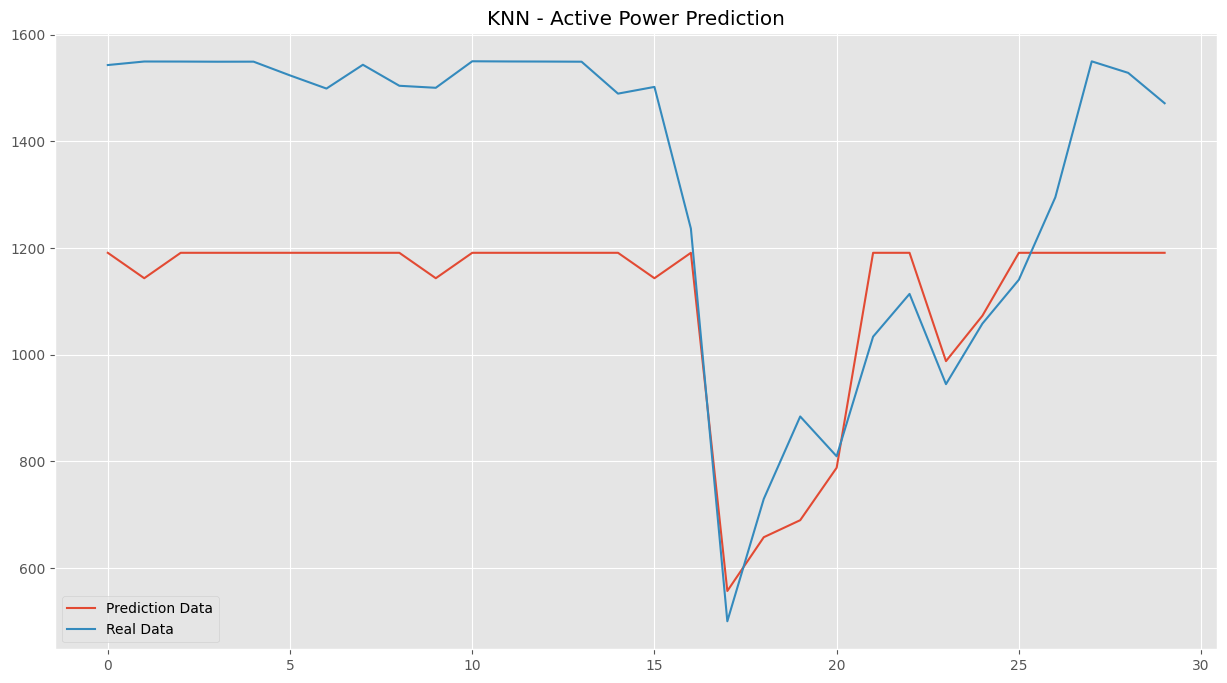

In [21]:
# Best KNN Model
print(f"Best trial config: {knn_study.best_params}")
print(f"Best trial final validation loss: {knn_study.best_value}")

print(best_knn.plot_accuracy())
print(best_knn.plot_loss())

best_knn.plot_prediction(test_dataset, target_transform=target_transform.inverse_transform)

Best trial config: {'lr': 0.01597381117174193, 'batch_size': 8, 'epochs': 300}
Best trial final validation loss: 0.27173253893852234


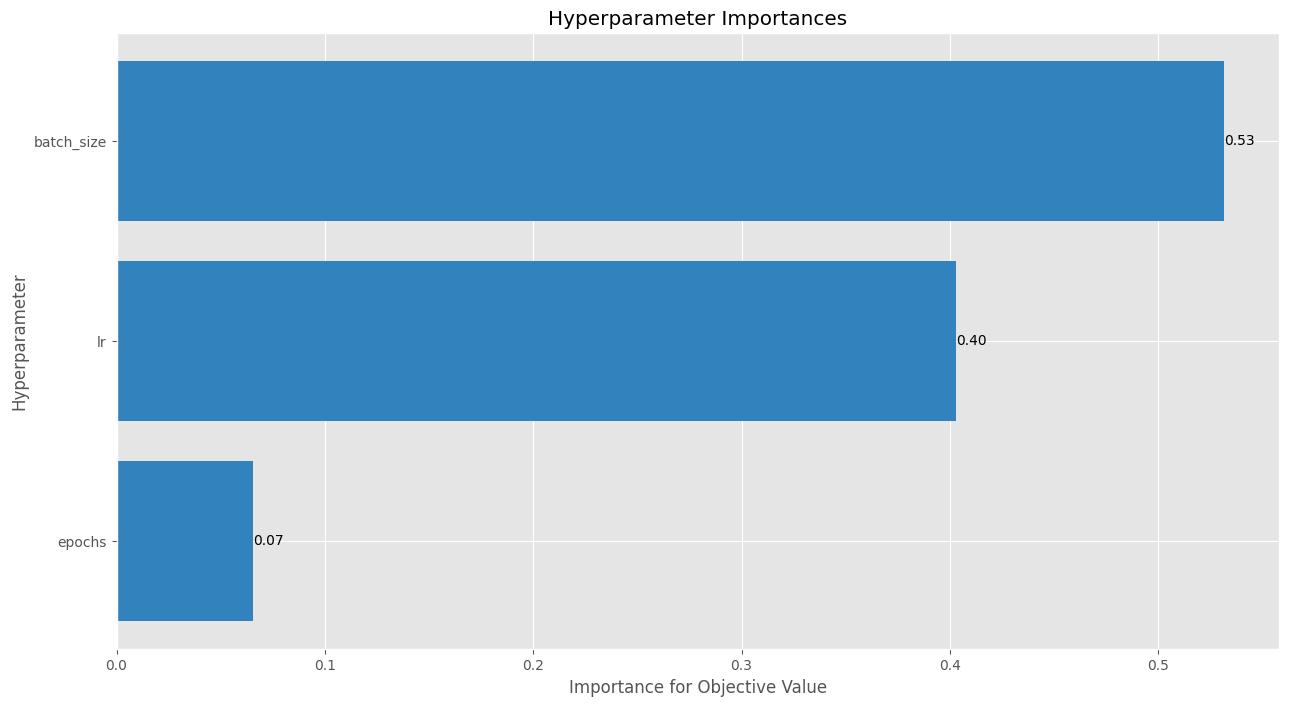

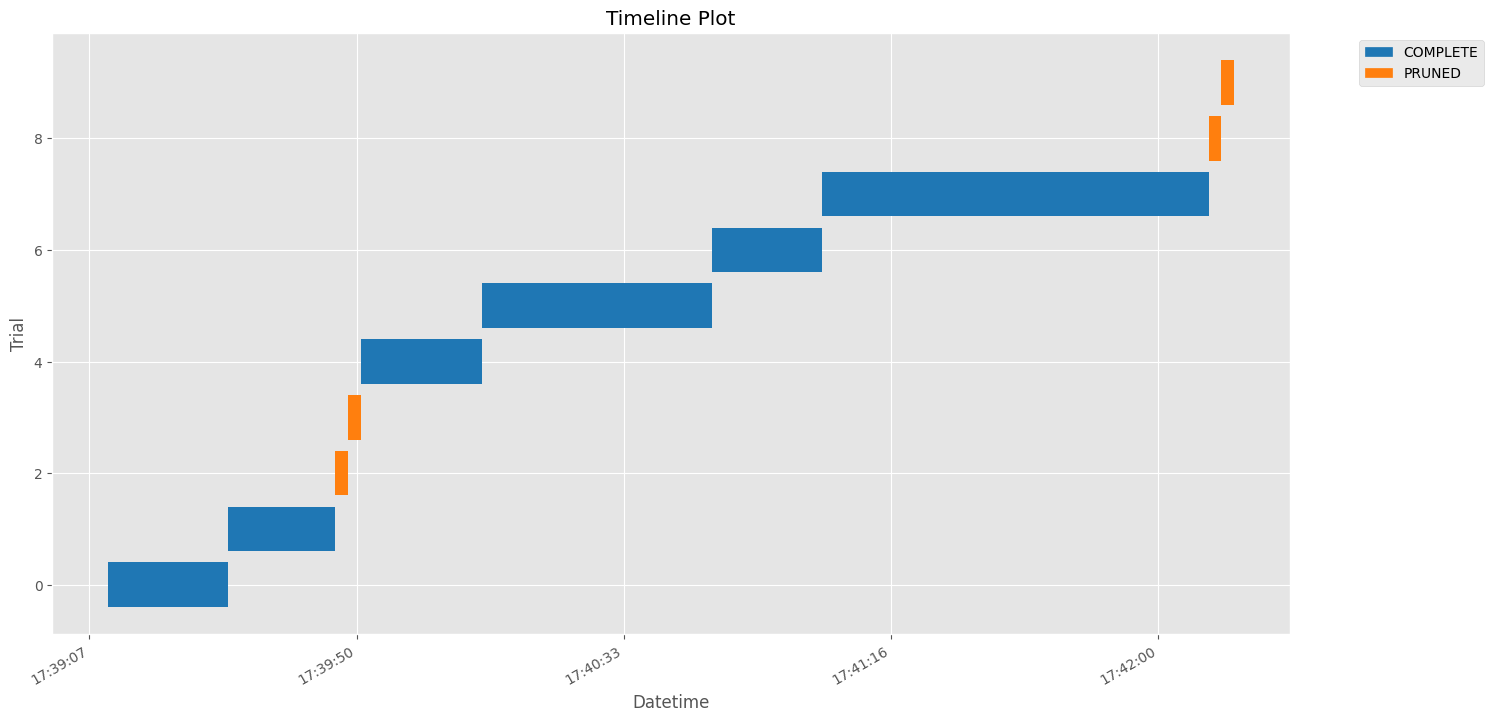

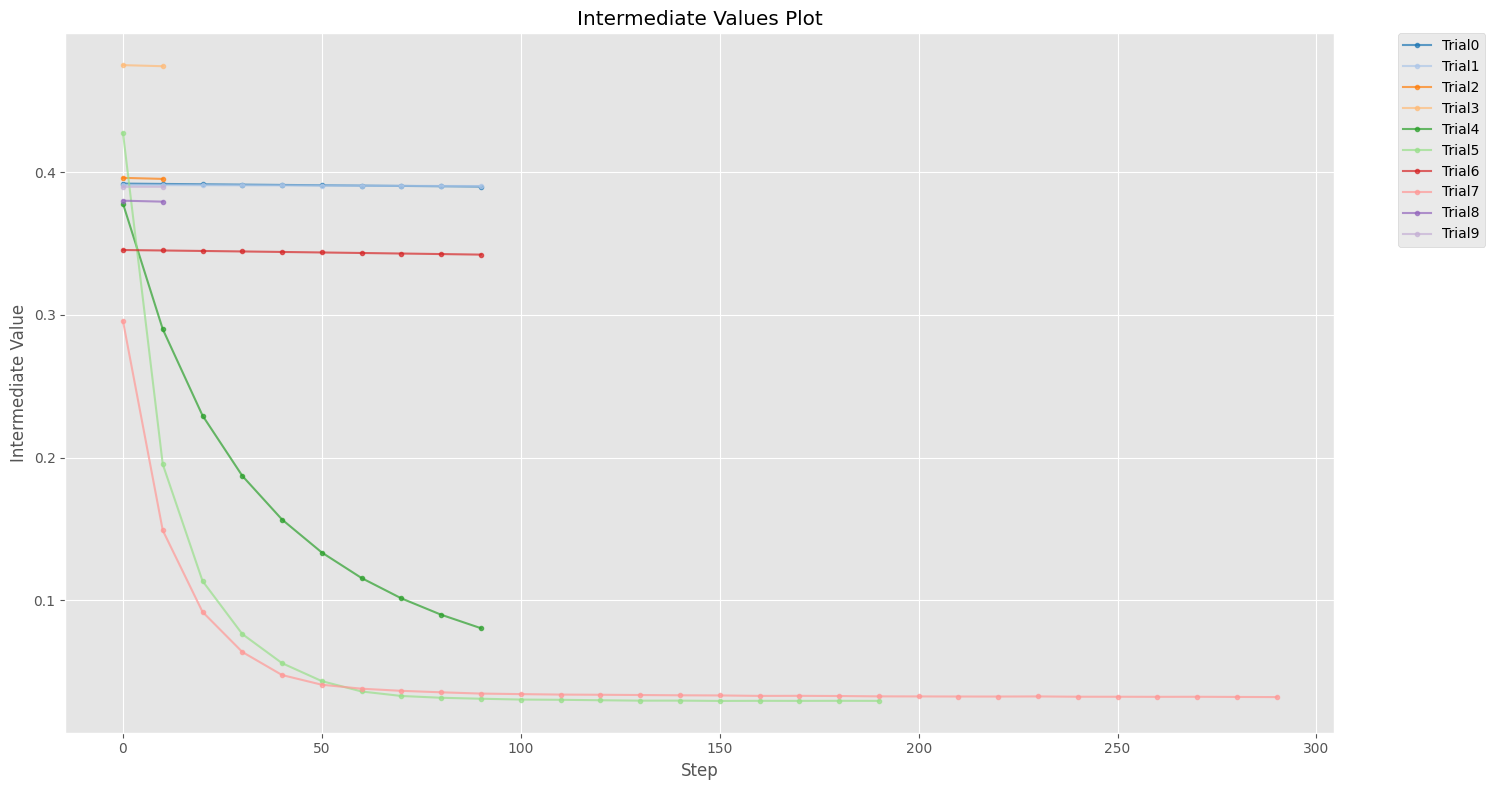

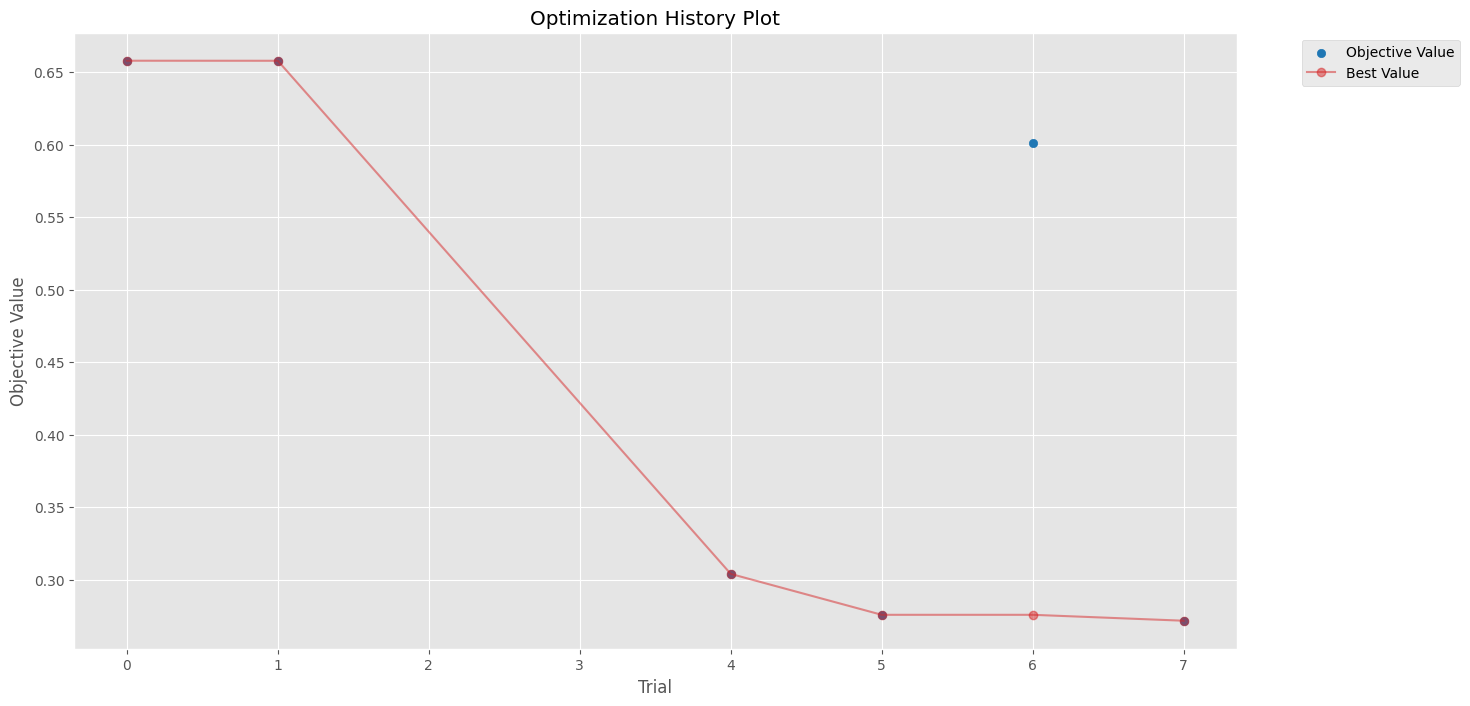

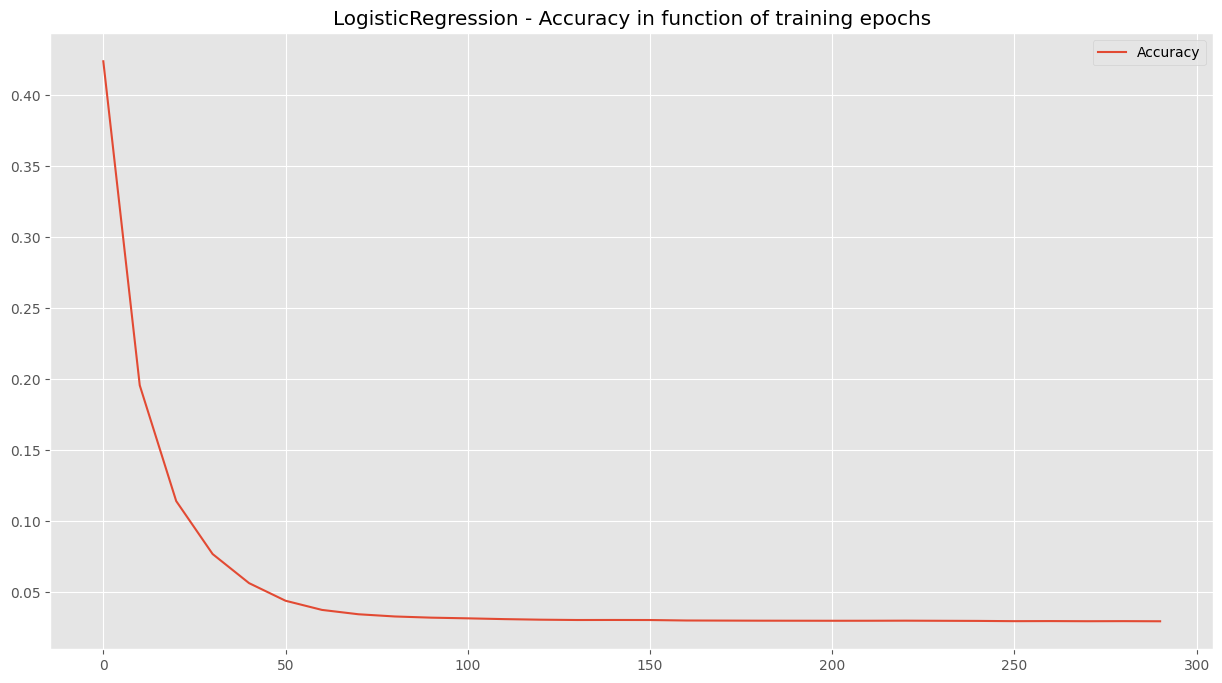

None


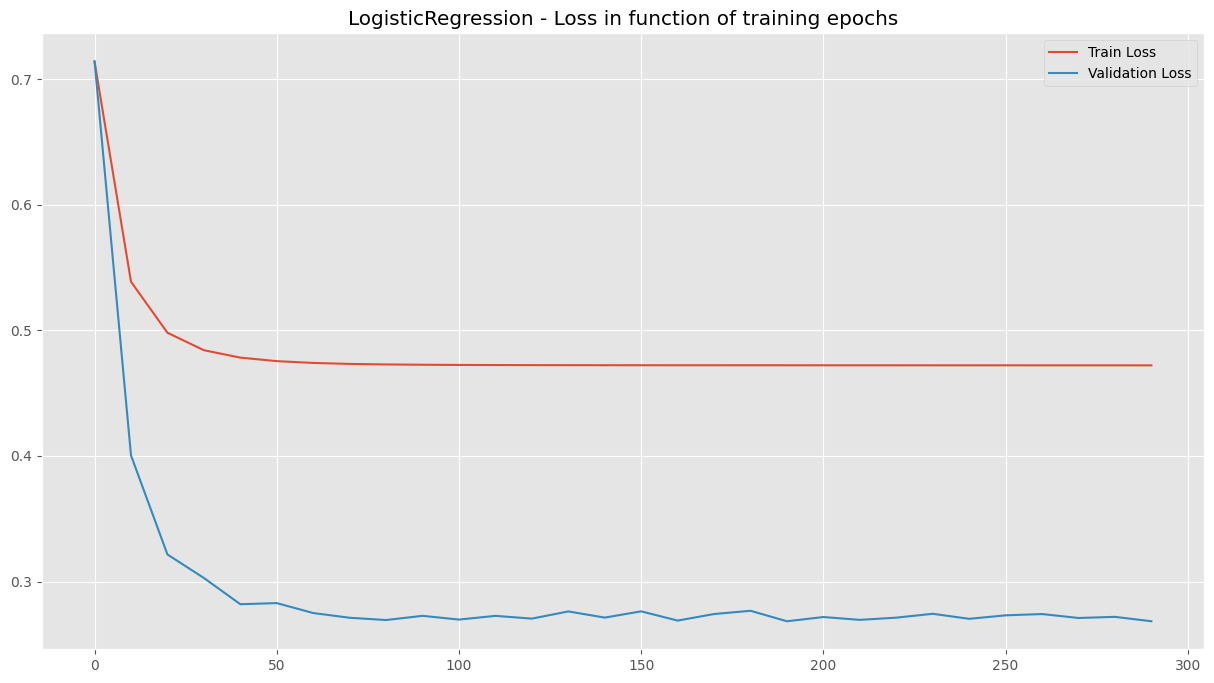

None


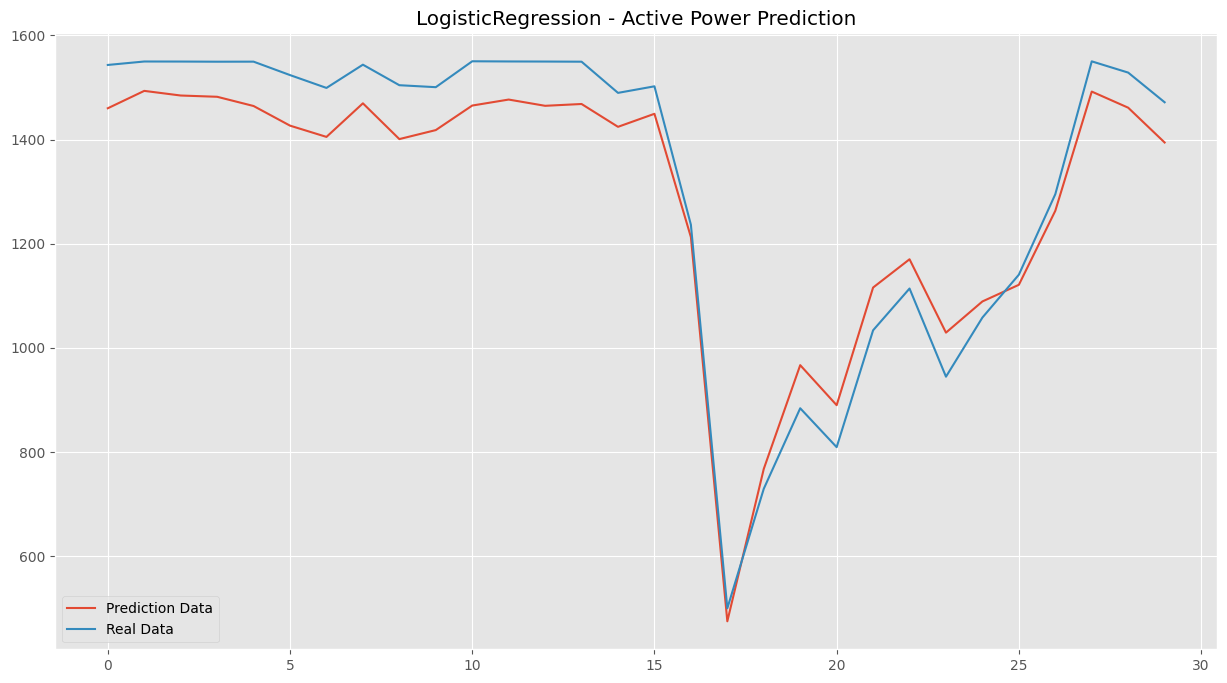

Saving self to ../saved_models/lreg_model.pt.


In [19]:
# Best Logistic Regression
print(f"Best trial config: {lreg_study.best_params}")
print(f"Best trial final validation loss: {lreg_study.best_value}")

optuna.visualization.matplotlib.plot_param_importances(lreg_study)
optuna.visualization.matplotlib.plot_timeline(lreg_study)
optuna.visualization.matplotlib.plot_intermediate_values(lreg_study)
optuna.visualization.matplotlib.plot_optimization_history(lreg_study)
plt.show()

print(best_lreg.plot_accuracy())
print(best_lreg.plot_loss())

best_lreg.plot_prediction(test_dataset, target_transform=target_transform.inverse_transform)

best_lreg.save('../saved_models/lreg_model.pt')

Best trial config: {'n_trees': 60, 'max_depth': 13, 'batch_size': 64, 'epochs': 400}
Best trial final validation loss: 0.0026359770086581214


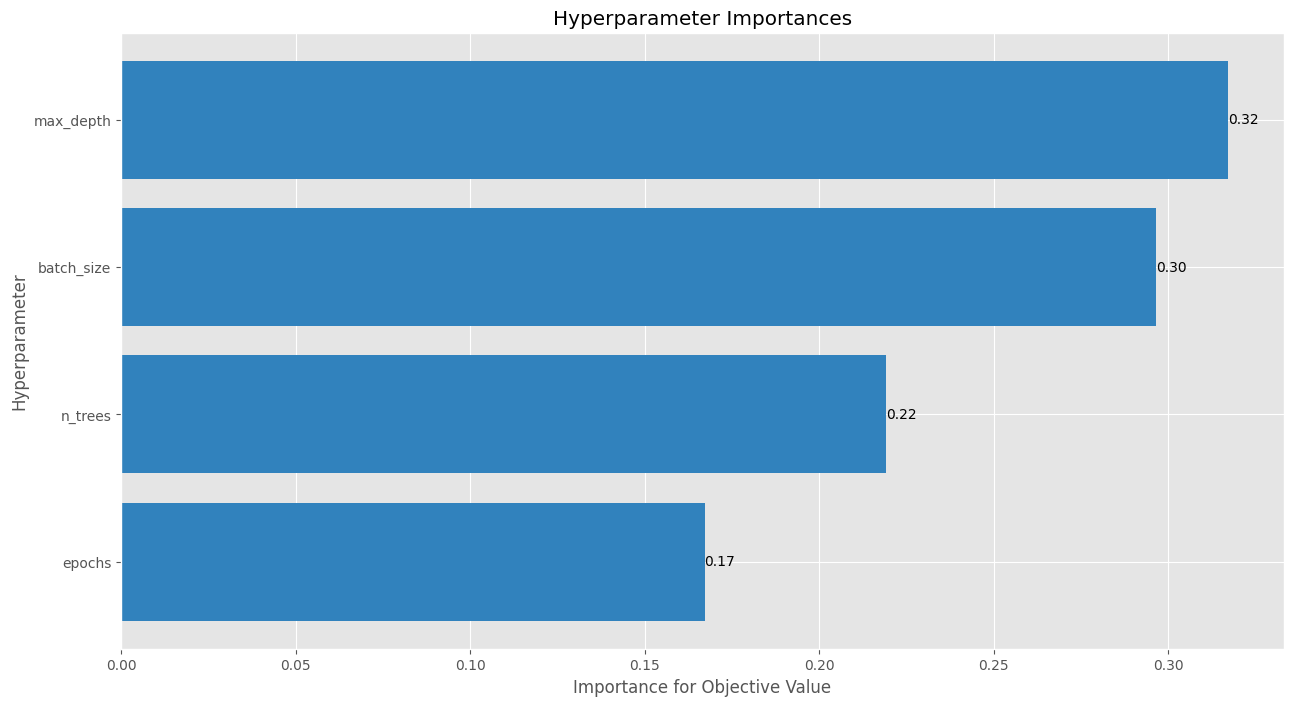

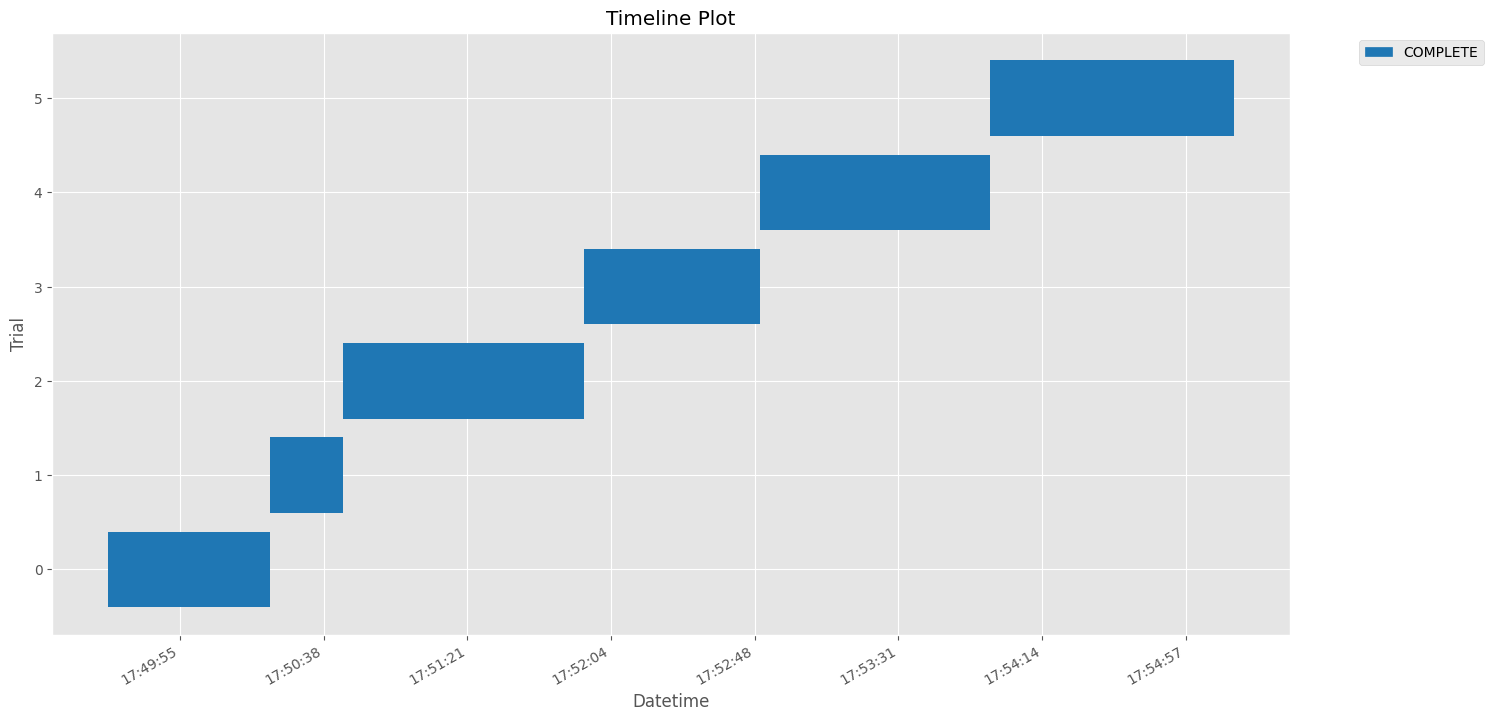

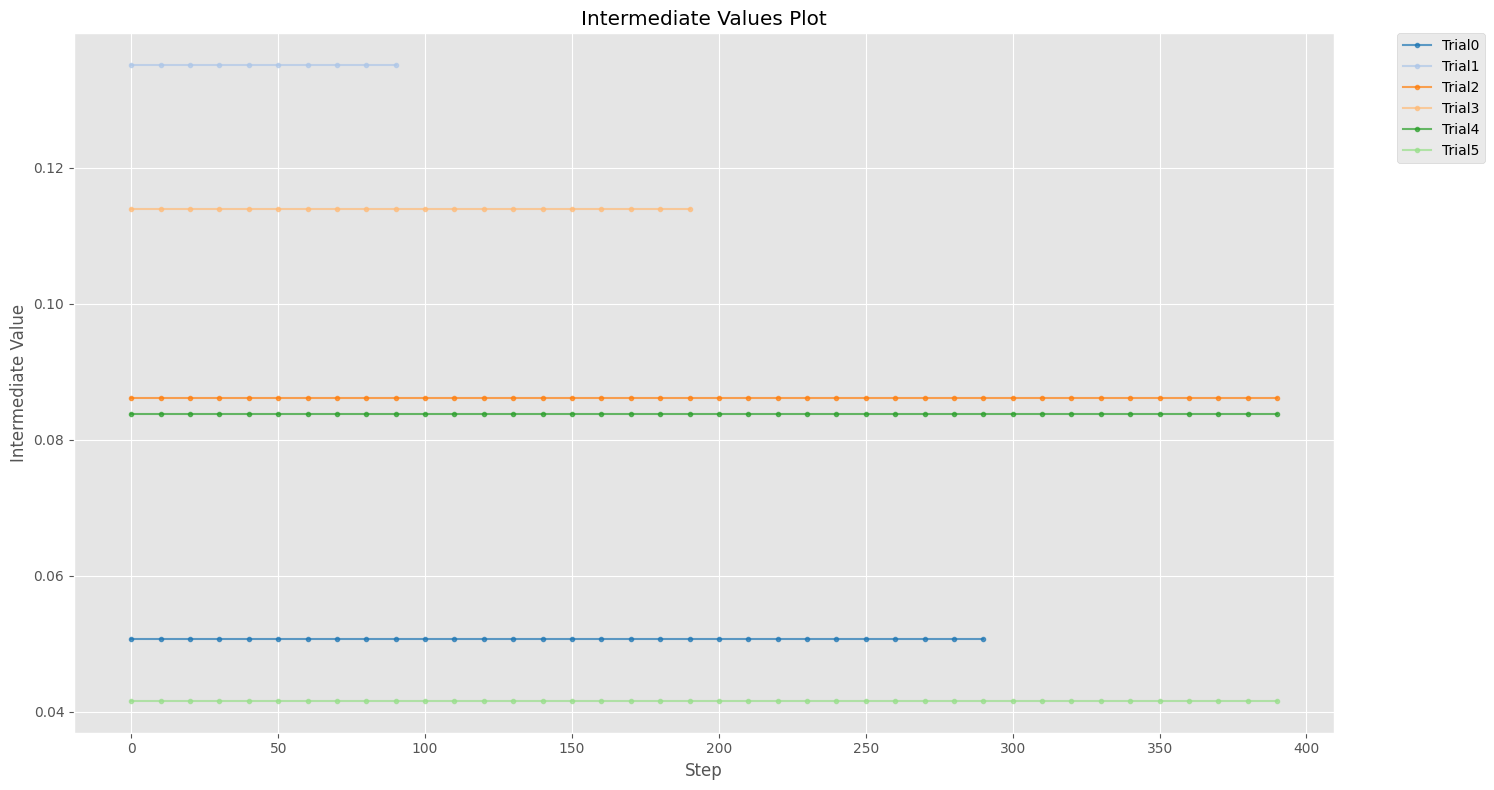

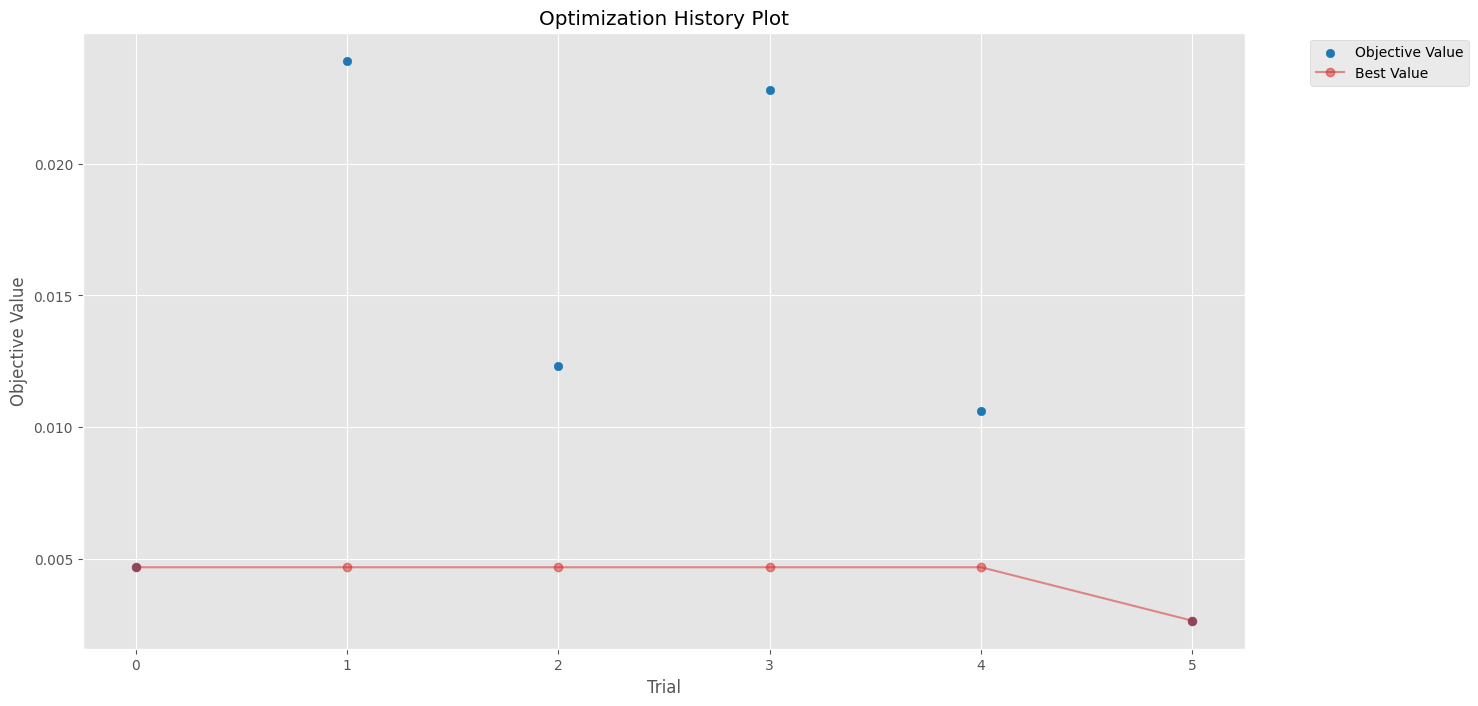

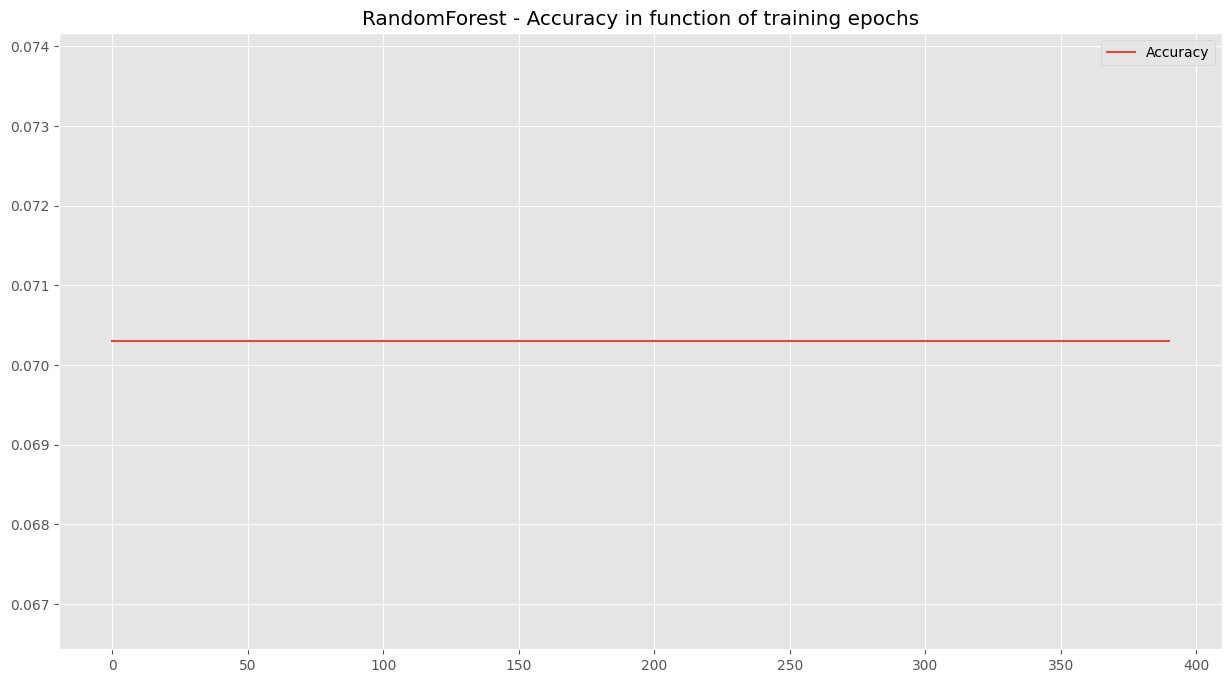

None


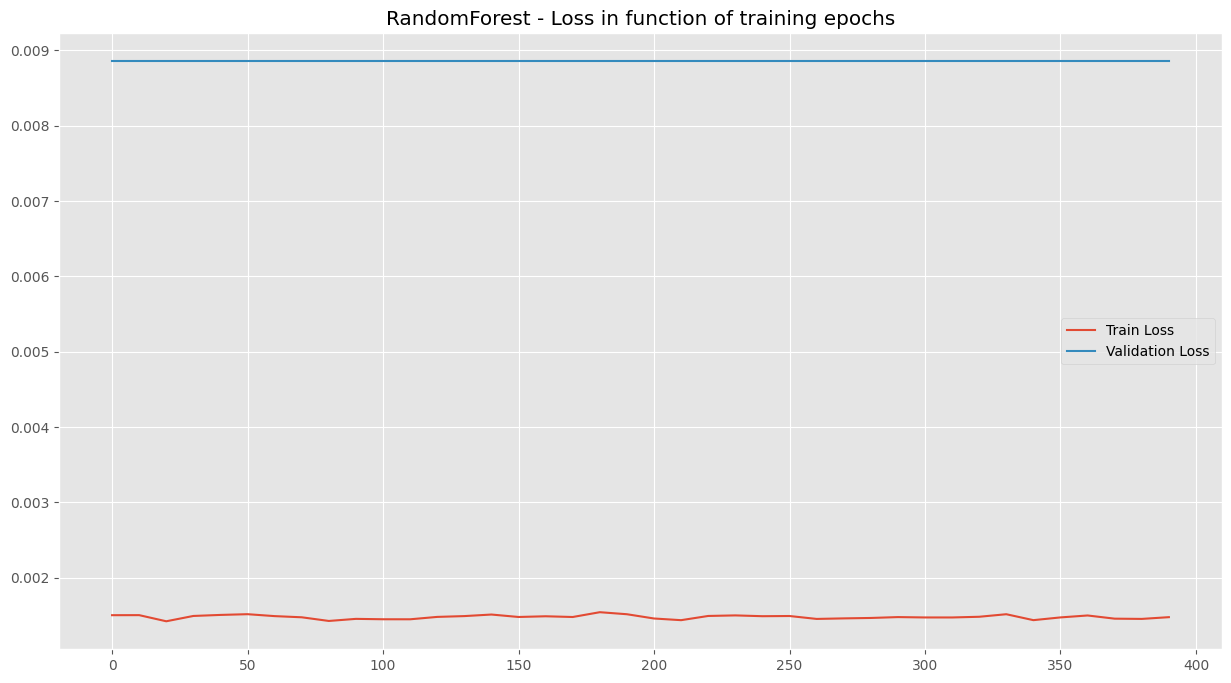

None


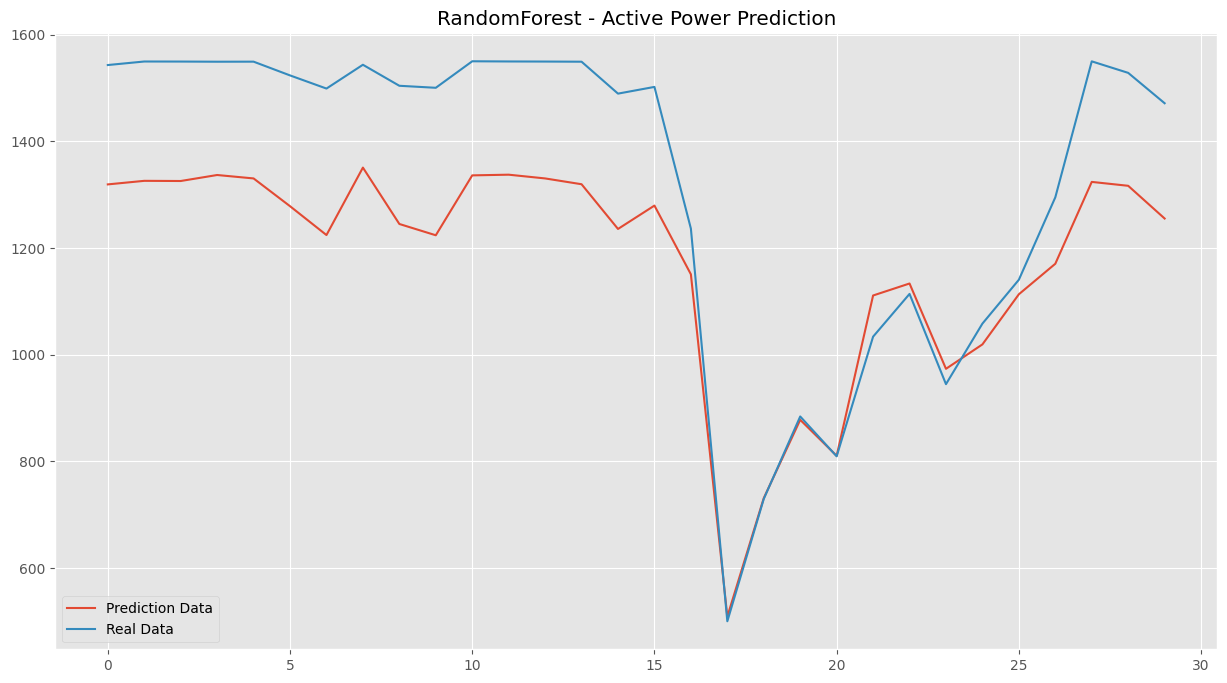

Saving self to ../saved_models/rf_model.pt.


PicklingError: Can't pickle <class 'models.random_forest.model.RandomForest'>: it's not the same object as models.random_forest.model.RandomForest

In [20]:
# Random Forest Regression
print(f"Best trial config: {rf_study.best_params}")
print(f"Best trial final validation loss: {rf_study.best_value}")

optuna.visualization.matplotlib.plot_param_importances(rf_study)
optuna.visualization.matplotlib.plot_timeline(rf_study)
optuna.visualization.matplotlib.plot_intermediate_values(rf_study)
optuna.visualization.matplotlib.plot_optimization_history(rf_study)

plt.show()

print(best_rf.plot_accuracy())
print(best_rf.plot_loss())

best_rf.plot_prediction(test_dataset, target_transform=target_transform.inverse_transform)

best_rf.save('../saved_models/rf_model.pt')

Best trial config: {'lr': 0.05664052573075681, 'hidden_size': 2, 'batch_size': 32, 'epochs': 100}
Best trial final validation loss: 0.0005065460572950542


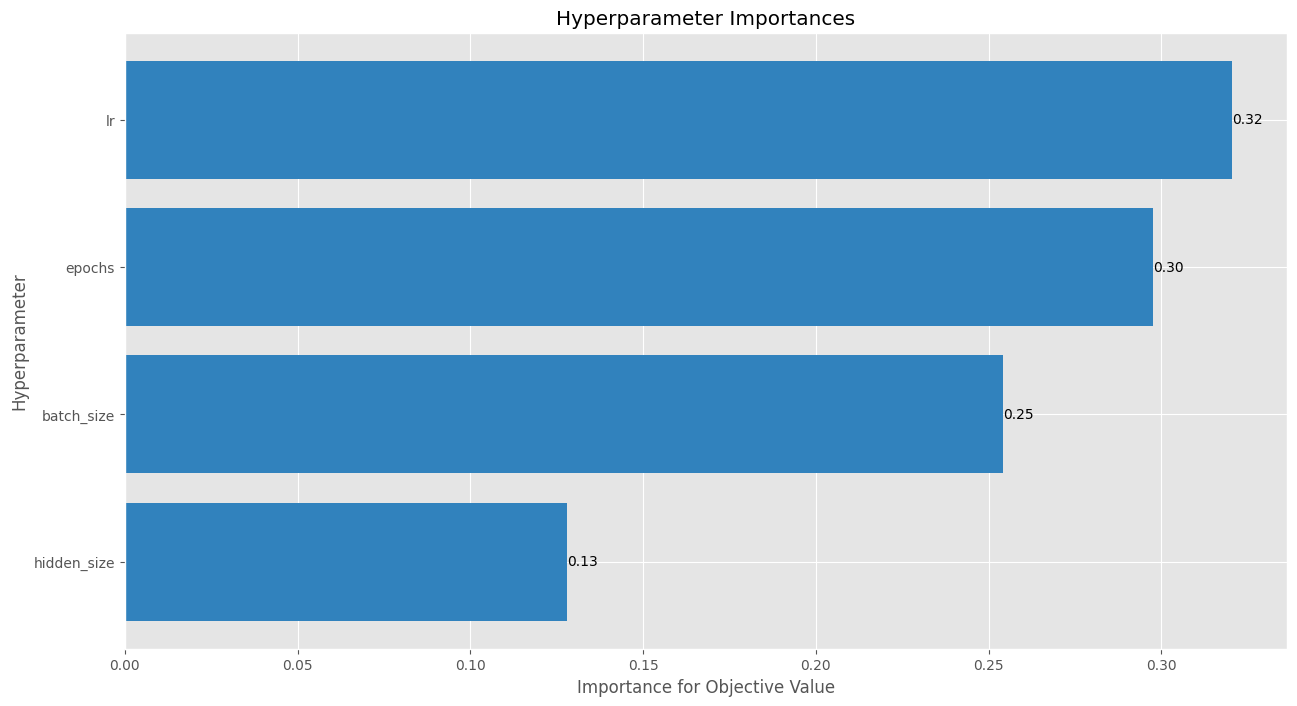

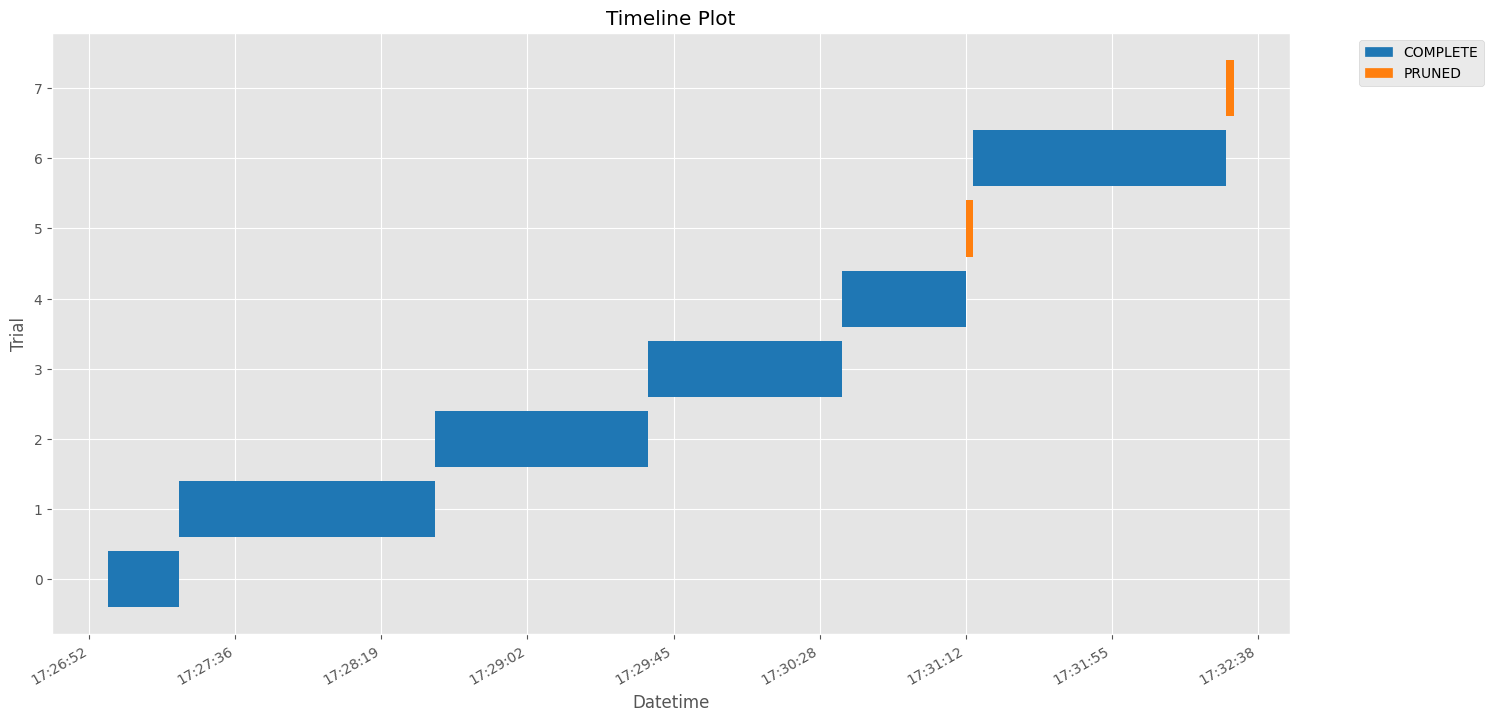

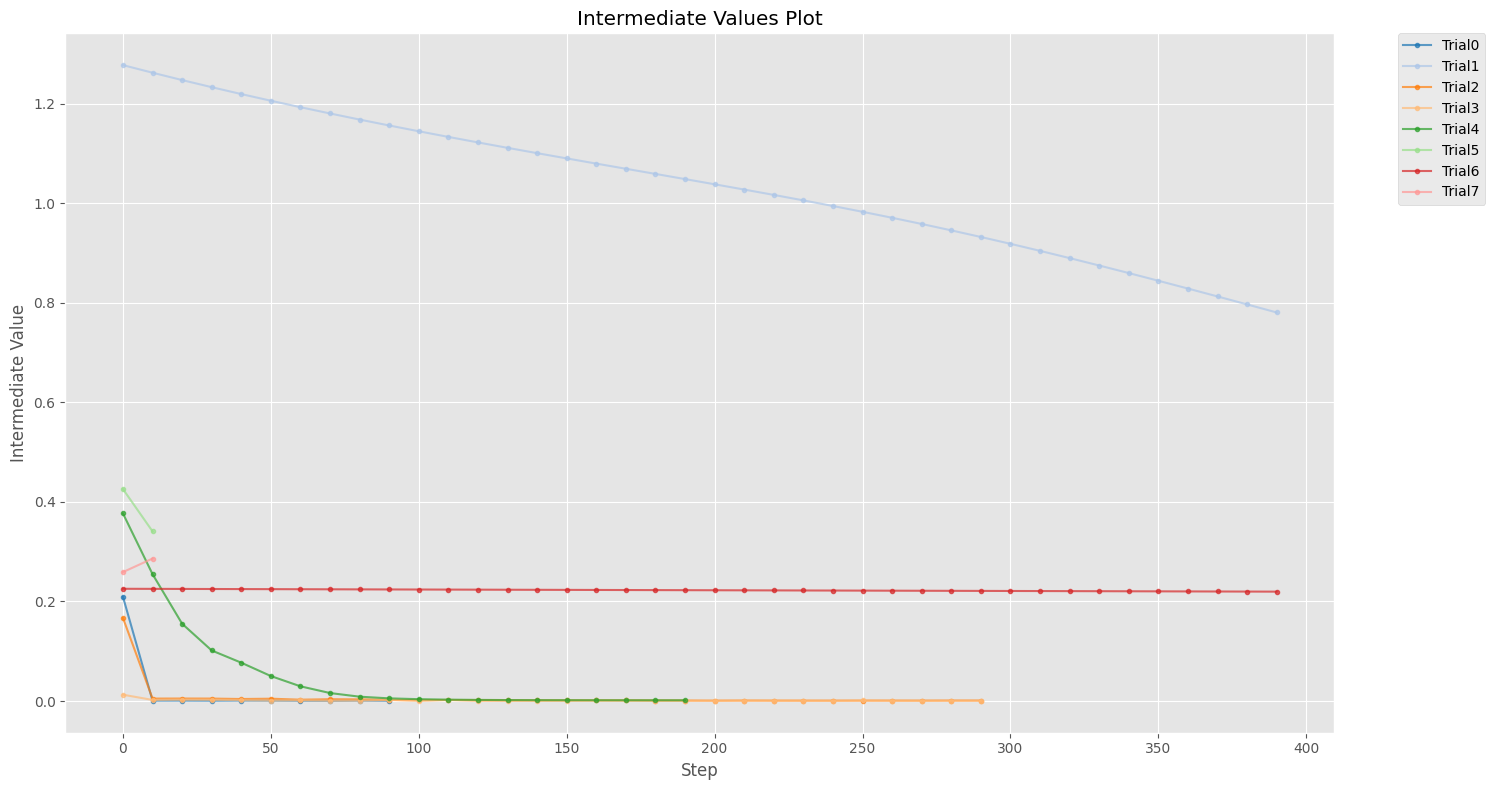

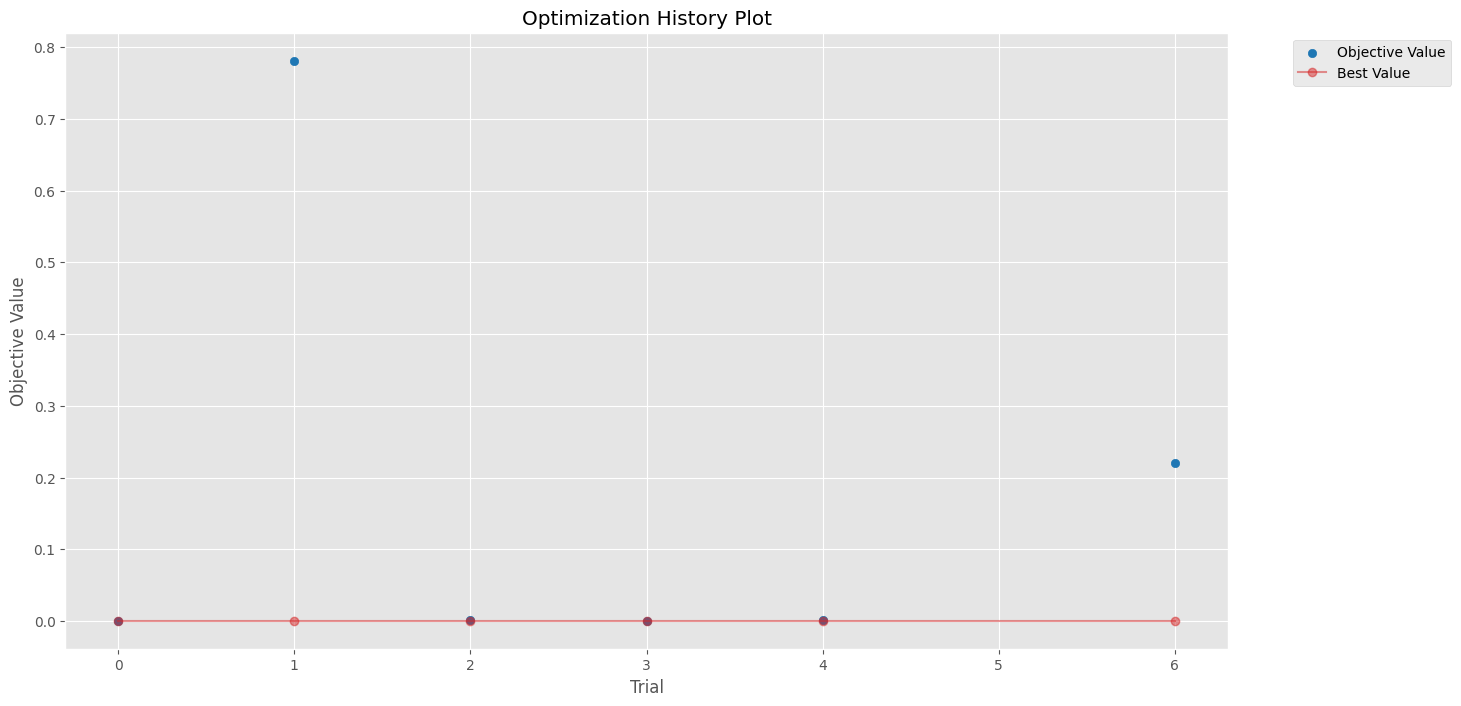

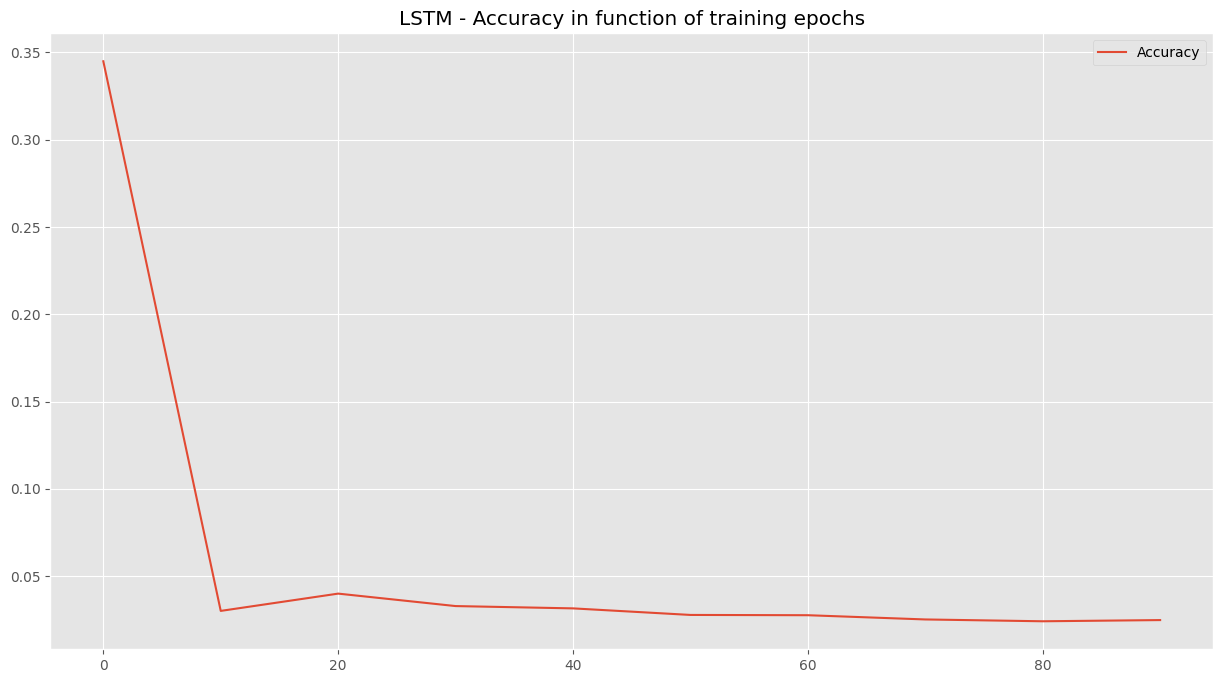

None


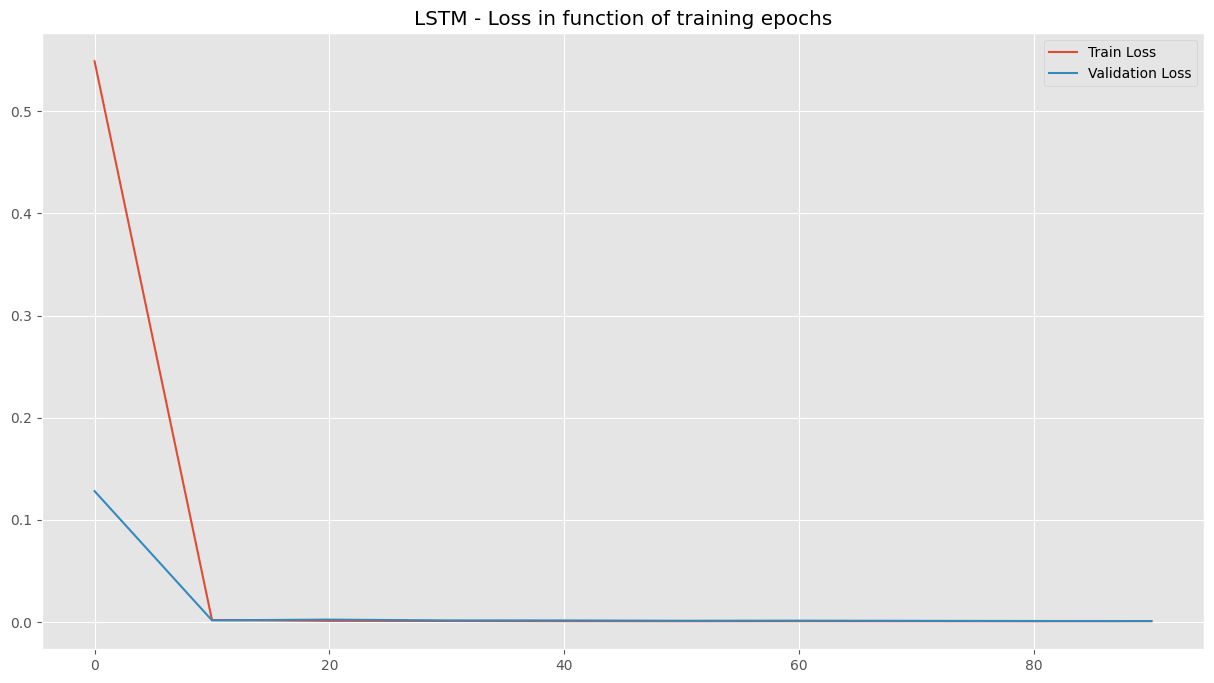

None


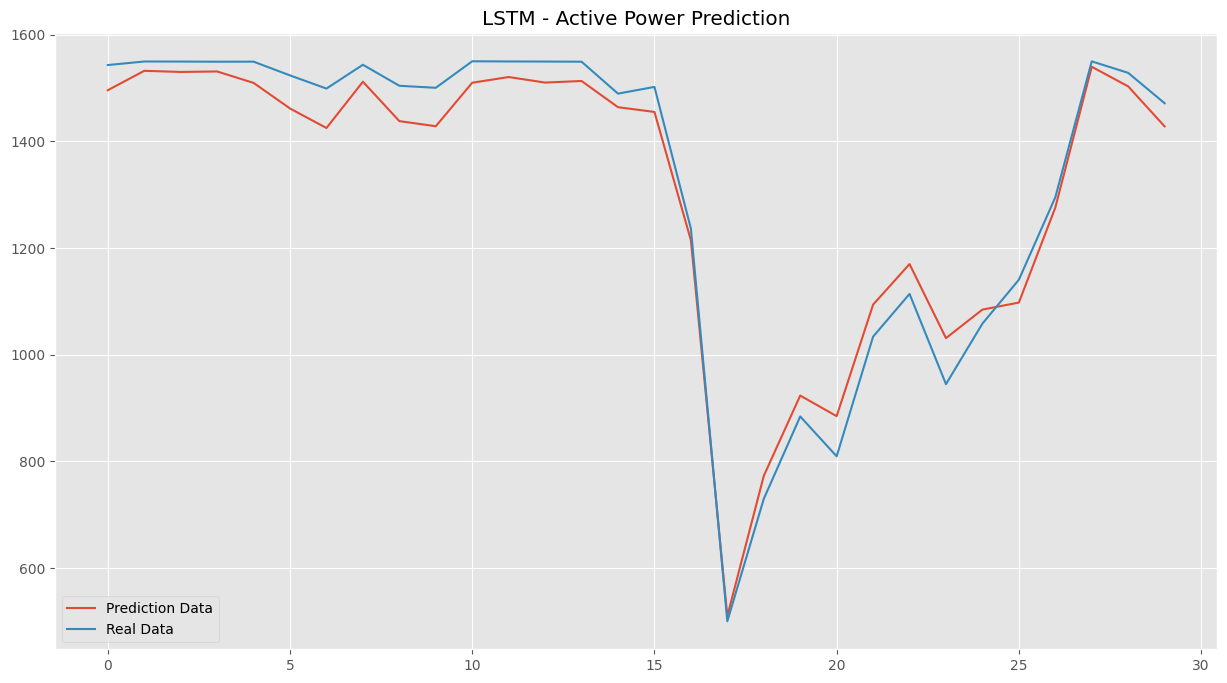

Saving self to ../saved_models/nn_model.pt.


In [ ]:
# Best Neural Network
print(f"Best trial config: {nn_study.best_params}")
print(f"Best trial final validation loss: {nn_study.best_value}")

optuna.visualization.matplotlib.plot_param_importances(nn_study)
optuna.visualization.matplotlib.plot_timeline(nn_study)
optuna.visualization.matplotlib.plot_intermediate_values(nn_study)
optuna.visualization.matplotlib.plot_optimization_history(nn_study)

plt.show()

print(best_nn.plot_accuracy())
print(best_nn.plot_loss())

best_nn.plot_prediction(test_dataset, target_transform=target_transform.inverse_transform)

best_nn.save('../saved_models/nn_model.pt')